In [1]:
exec(open("init_notebook.py").read())
%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(39)
logfile = "2-client-debug.log"
with open(logfile, 'w') as f:
    f.truncate()
logging.basicConfig(level=logging.DEBUG, filename=logfile)
print(f"Logging file at: {logfile}")

config = Configuration()
timeResolutionUnit = config.get('timeResolutionUnit')
network = Network.get()
nodeManager = NodeManager(timeResolutionUnit)
analyzer = AnalyzerTools()

Logging file at: 2-client-debug.log


In [3]:
from experiment.RTTAdaptiveClient import RTTAdaptiveClient
# from experiment.PowerAdaptiveClient import PowerAdaptiveClient
clientManager = ClientManager(timeResolutionUnit, debug=True)
clients = clientManager.createTCPClients(1, deliveryRatePerS=10000, max_outstanding_packets=10)
client = clients[0]
client2 = clientManager.createRTTAdaptiveClient(rttWindowSize=5, bandWidthWindowSize=5, deliveryRatePerS=10000, max_outstanding_packets=10)
# client2 = clientManager.createPowerAdaptiveClient(rttWindowSize=5, bandWidthWindowSize=5, deliveryRatePerS=10000, max_outstanding_packets=10)


In [4]:
nodes = [
    nodeManager.createSimpleNode(maxDeliveryRate=10000, debug=True),
    nodeManager.createSimpleNode(maxDeliveryRate=2000, debug=True),
    nodeManager.createSimpleNode(maxDeliveryRate=5000, debug=True),
    nodeManager.createSimpleNode(maxDeliveryRate=3000, debug=True)
]
nodes2 = [
    nodeManager.createSimpleNode(maxDeliveryRate=1500, debug=True),
    nodes[1],
    nodeManager.createSimpleNode(maxDeliveryRate=5000, debug=True)
]

server = Server(-1)
server2 = Server(-2)

path = network.createPath(client=client, nodes=nodes, server=server)
path2 = network.createPath(client=client2, nodes=nodes2, server=server2)

In [5]:
logging.info("path for client1:" + str([node.id for node in path.getNodesWithServer()]))
logging.info("path for client2:" + str([node.id for node in path2.getNodesWithServer()]))
print("path for client1:" + str([node.id for node in path.getNodesWithServer()]))
print("path for client2:" + str([node.id for node in path2.getNodesWithServer()]))

path for client1:[1, 2, 3, 4, -1]
path for client2:[5, 2, 6, -2]


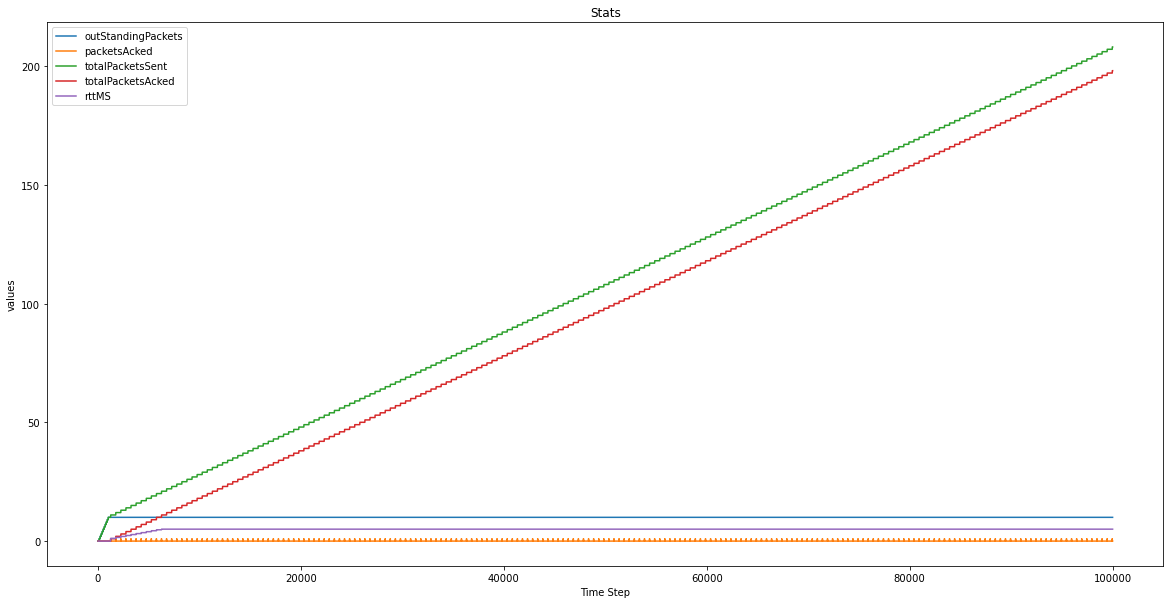

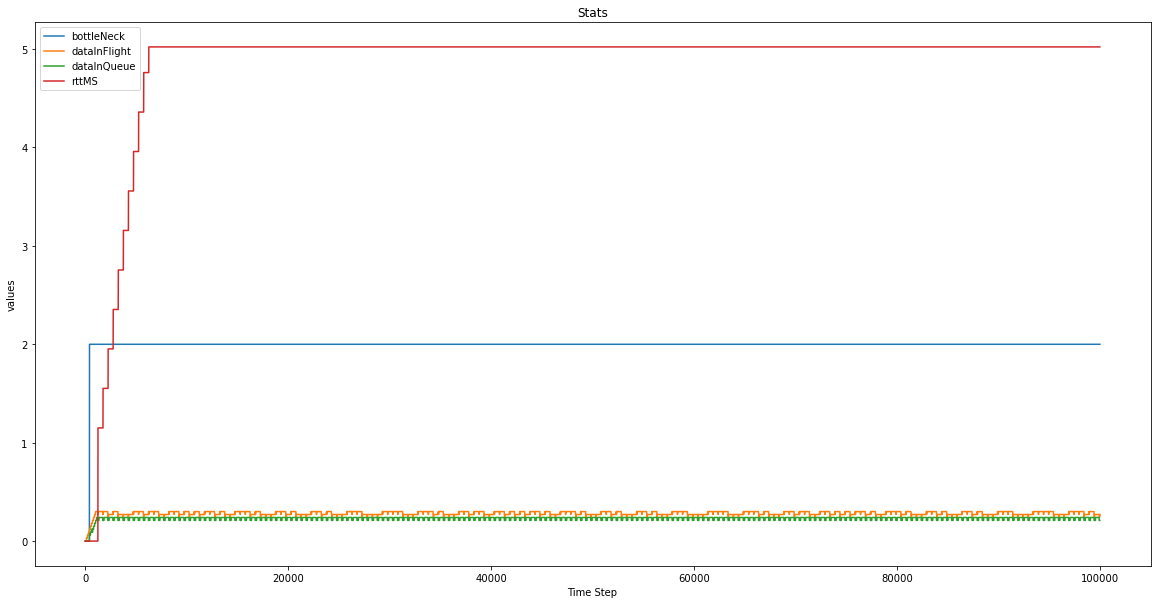

In [6]:
nodeManager.reset()
simulator = EventSimulator(timeResolutionUnit=timeResolutionUnit, debug=True)
simulator.addClient(client)
maxSteps = 100000 # equivalent to maxStep timeResolution unit
simulator.run(maxSteps)
# client 1 stats
analyzer.createPlotsForTimeSteps(client.stats, ['outStandingPackets', 'packetsAcked', 'totalPacketsSent', 'totalPacketsAcked', 'rttMS'])
analyzer.createPlotsForTimeSteps(client.stats, ['bottleNeck', 'dataInFlight', 'dataInQueue', 'rttMS'])

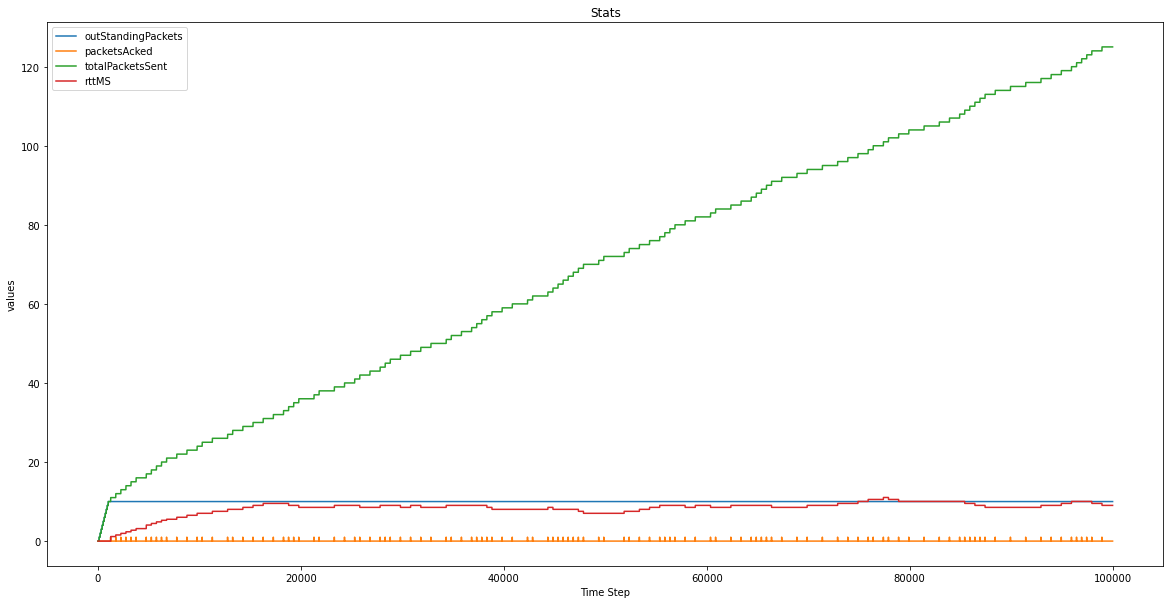

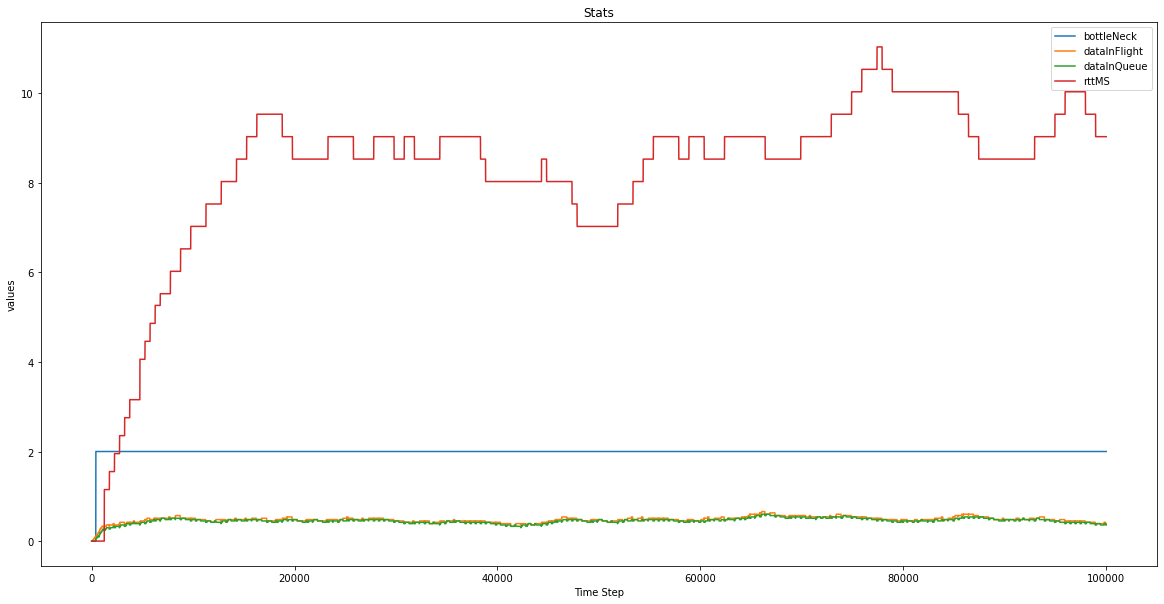

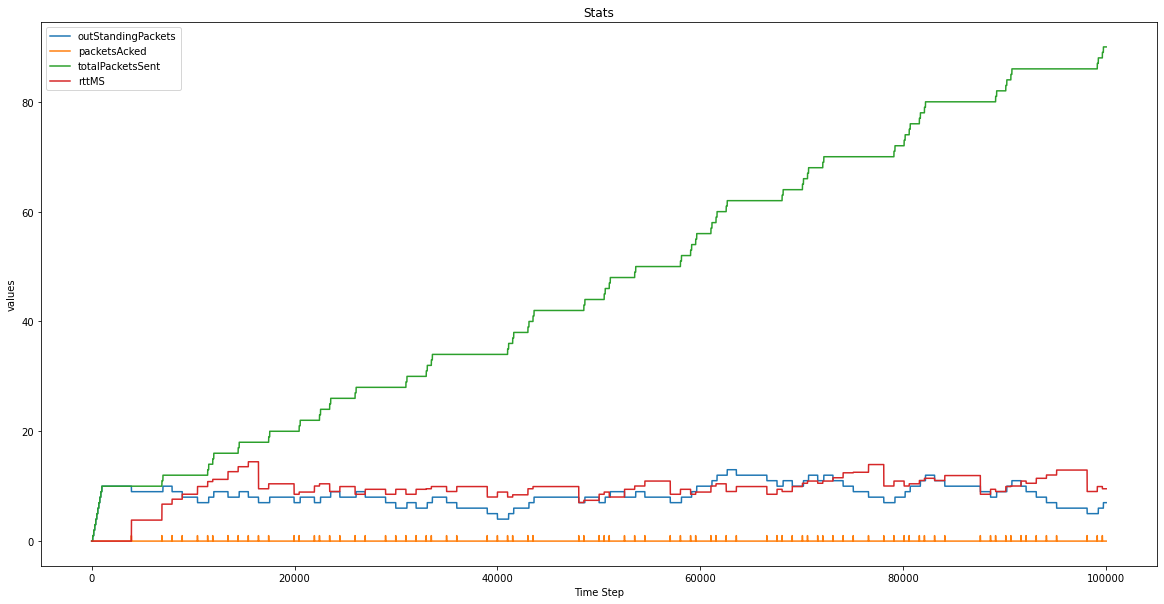

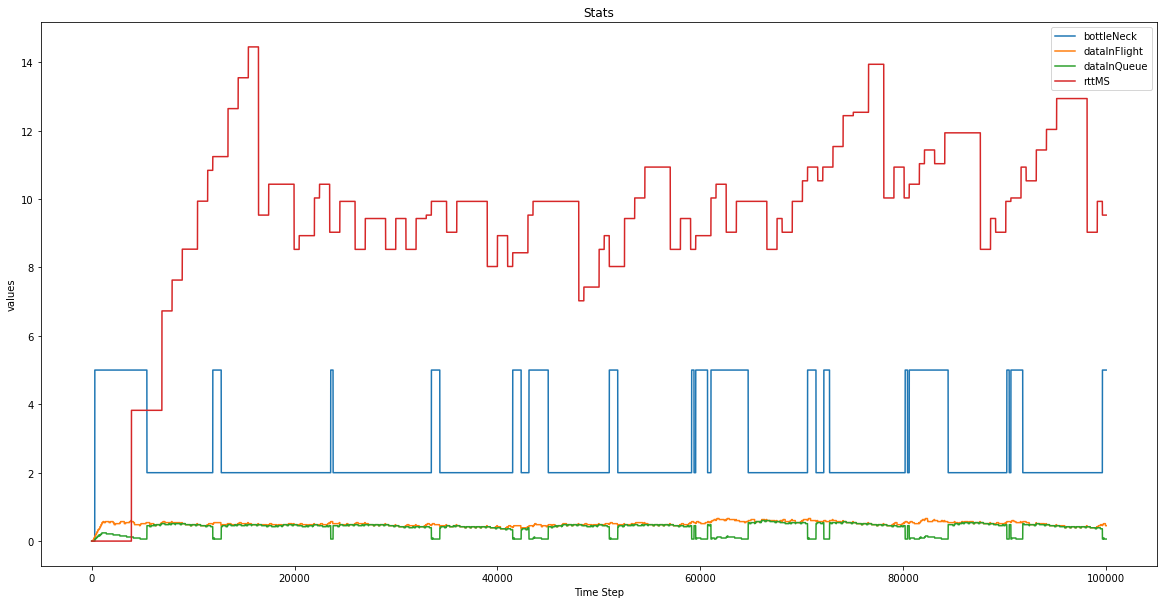

In [7]:
nodeManager.reset()
simulator = EventSimulator(timeResolutionUnit=timeResolutionUnit, debug=False)
simulator.addClient(client)
simulator.addClient(client2)

maxSteps = 100000 # equivalent to maxStep timeResolution unit
simulator.run(maxSteps)
# client 1 stats
analyzer.createPlotsForTimeSteps(client.stats, ['outStandingPackets', 'packetsAcked', 'totalPacketsSent', 'rttMS'])
analyzer.createPlotsForTimeSteps(client.stats, ['bottleNeck', 'dataInFlight', 'dataInQueue', 'rttMS'])
# client 2 stats
analyzer.createPlotsForTimeSteps(client2.stats, ['outStandingPackets', 'packetsAcked', 'totalPacketsSent', 'rttMS'])
analyzer.createPlotsForTimeSteps(client2.stats, ['bottleNeck', 'dataInFlight', 'dataInQueue', 'rttMS'])

# Summary: bottleneck of client 2 shifts from node 5 to node 2 after a while. That changes the rtt of client 1. Both clients utilize 50% capacity of the network.